## Create cost surfaces 
This notebook creates a set of cost distance arrays, one for each biogas source, saving them as array stacks. The outputs are `Stack.npy` and `TraceStack.npy`, which are stacks of raw cost distance and cost traceback arrays, respectively. These outputs serve as inputs for cost surface analyses in subsequent notebooks. 

### Data requirements
This analysis requires a **cost surface** and a listing of **biogas source locations with attributes**. 

The cost surface used here is the MIT cost surface for the US whose pixel values represent cost multipliers for a given pipeline cost (which itself is based on the through put volume). 

The biogas source locations and attributes are extracted from an Excel table which includes fields on *farm type*, *head count*, and coordinates of the source (*longitude* & *latitude*). 

### Workflow
* Analysis begins by reading in the biogas source data into a dataframe and computing [1] biogas potential (cu. ft./yr) and [2] 15-year biogas transport values ($/mi-MMBtu) from each source's head count and farm type.

* The dataframe is then converted into a geodataframe using the coordinate columns, and sorted on biogas potential, from largest to smallest (to prioritize large farms in constructing a connected pipeline framework). 

* Then the US cost surface raster dataset is read in and subset to the extent of the biogas geodataframe (transformed to match the coordinate reference system of the cost surface). A buffer of 10km is applied to the biogas sources to allow least cost analysis to explore paths slightly outside the minimum bounding box. 

* Next, the analysis iterates through each biogas record, generating an adjusted cost surface by multiplying the MIT cost surface by the biogas site's transport cost value. Then a cost distance surface and cost traceback surface are computed from the biogas source location and the adjusted cost surface. 

* At each iteration above, the resulting cost distance and traceback surfaces are cumulatively added to a list of surfaces. These surface array lists are then stacked into 3-d arrays (D1 = biogas source, D2 = y-offset, D3 = x-offset) and saved to disk for access by later scripts. 

```
Author: John.Fay@duke.edu
Date: May 2020
```

In [1]:
#Import packages
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
import osmnx as ox
from pyproj import CRS
import rasterio
from rasterio import features, plot
import rasterio.mask
from matplotlib import pyplot as plt
from skimage import graph                   

### Read in the biogas location data
These data are stored as the "Swine" sheet in the "NC_Biogas_Potential.xlsx" file. These records include the lat/long coordinates of each swine lagoon as well as its biogas potential in ($f^3/yr$). 
* First, calculations must be made to convert the potential into cost to pipe ($\$/{mi-MMBtu@15yr}$).
* Then the data must be converted to a geodataframe and transformed to match the coordinate reference system of the cost surface.

In [2]:
#Read in biogas sources (example: Duplin Co)
dfBG =  pd.read_excel('../data/NC_Biogas_Potential.xlsx',sheet_name='Swine')
#Remove the total row
dfBG = dfBG.loc[dfBG['Facility Name']!='TOTAL']

#### Create a dataframe of per-yead yield by farm type

In [3]:
#Create a dataframe of per-yead yield by farm type
biogas_methane_content = 0.60 #B3 
biogas_CO2_content = 0.40     #B2
MMBtu_per_tsf = 1.037         #C6


#Create dataframe of type and biogas yield
df_farm_type_yield = pd.DataFrame(data = [['Swine - Feeder to Finish', 2336],
                                          ['Swine - Wean to Feeder', 420], 
                                          ['Swine - Wean to Finish', 2068], 
                                          ['Swine - Farrow to Wean', 1183],
                                          ['Swine - Farrow to Finish',1603]],
                                  columns = ['farm type','biogas (scf/y)'])

#Compute methane yield from biogas and constants
df_farm_type_yield['methane (MMBtu/year)'] = (df_farm_type_yield['biogas (scf/y)'] * 
                                              biogas_methane_content *
                                              MMBtu_per_tsf / 1000)

#Set the index to the farm type
df_farm_type_yield.set_index('farm type',inplace=True)

#Reveal the table
df_farm_type_yield

,biogas (scf/y),methane (MMBtu/year)
farm type,,
Swine - Feeder to Finish,2336,1.453459
Swine - Wean to Feeder,420,0.261324
Swine - Wean to Finish,2068,1.286710
Swine - Farrow to Wean,1183,0.736063
Swine - Farrow to Finish,1603,0.997387


#### Conversions
Construct a function that computes hourly methane yield for each lagoon based on its farm type and head count

In [4]:
#Calculate cost per mile-MMBtu over 15 years for a source, given its farm type and head_count
def compute_cost(head_count, farm_type):
    #Constants
    hours_per_year = 365 * 24                       #C6
    low_pressure_diameter_power = 0.394185319       #C62
    low_pressure_diameter_coefficient = 0.050593064 #C63
    cost_curve_slope = -7.4295332                   #G21
    cost_curve_intercept = 69.5084756               #H21
    low_pressure_cost_power = 0.485441535           #G62
    low_pressure_cost_coefficient = 10829.06613     #G63
    
    #Check that farm yield data exist, return NoData if not
    if farm_type not in df_farm_type_yield.index or head_count == 0:
        return np.nan

    #Compute biogas yield feed flow (scf/h) from farm type and head count
    lagoon_biogas_feed_flow = df_farm_type_yield.loc[farm_type,'biogas (scf/y)'] * head_count / hours_per_year 

    #Compute hourly methane yield (MMBtu/yr) from farm type and head count
    lagoon_methane_yield_yr = df_farm_type_yield.loc[farm_type,'methane (MMBtu/year)'] * head_count 

    #Compute annual methane yield (scf/h) from hourly yield
    lagoon_methane_yield_hr = lagoon_methane_yield_yr / hours_per_year * 1000 * MMBtu_per_tsf

    #Compute pipe diameter (in.) from hourly methane yield & coefficients
    pipe_diameter = low_pressure_diameter_coefficient * (lagoon_methane_yield_hr**low_pressure_diameter_power)

    #Compute production cost ($/MMBtu) from feed rate & coefficients
    pipe_cost = cost_curve_slope * np.log(lagoon_biogas_feed_flow) + cost_curve_intercept

    #Compute total production cost
    cost_per_year = lagoon_methane_yield_yr * pipe_cost

    #Compute cost per mile (low pressure)
    cost_per_mile = low_pressure_cost_coefficient * pipe_diameter**low_pressure_cost_power

    #Compute 15-year cost per MMBtu
    cost_per_MMBtu_15 = cost_per_mile / (lagoon_methane_yield_yr * 15)
    
    #Return the total cost
    return cost_per_MMBtu_15

In [5]:
#Apply the function
dfBG['Pipe Cost ($/mi-MMBtu@15y)'] = dfBG.apply(lambda x: compute_cost(x['Allowable Count'],x['Regulated Activity']),axis=1)

In [6]:
#Drop "missing" sites
dfBG = dfBG.dropna(subset=['Pipe Cost ($/mi-MMBtu@15y)'])

In [7]:
#Sort values in ascending order by biogas potential
dfBG = dfBG.sort_values(by='Biogas Potential (f^3 / year)',
                        ascending=False).reset_index()
#Save the data as a csv file
dfBG.to_csv('../data/BiogasData.csv',index=False)

### Read in the cost surface raster

In [8]:
#Load the cost surface raster
cost_surface_dataset = rasterio.open('../data/MIT_Surface_Full/costsurface500m.img')
#Extract the coordinate reference system
cost_crs = cost_surface_dataset.crs

### Convert the biogas dataframe to a geodataframe

In [9]:
#Convert to geodataframe from lat/lng coordinates
geom = [Point(xy) for xy in zip(dfBG['Longitude'],dfBG['Latitude'])]
gdfBG = gpd.GeoDataFrame(dfBG,geometry=geom,crs=4326)

In [10]:
#Subset points falling in Duplin County
#duplin_co = ox.gdf_from_place('Duplin County, NC').unary_union
#gdfBG = gdfBG.loc[gdfBG.geometry.within(duplin_co)]

In [11]:
#Project to same crs as raster
gdfBG = gdfBG.to_crs(cost_crs)

In [12]:
#Subset records intersecting cost surface
bbox = box(*cost_surface_dataset.bounds)
gdfBG = gdfBG.loc[gdfBG.geometry.within(bbox)]

#### Subset the cost raster

In [13]:
#Subset the raster to the extent of the biogas locations
the_bounds = box(*gdfBG.geometry.unary_union.buffer(10000).bounds)
out_image, out_transform = rasterio.mask.mask(cost_surface_dataset,[the_bounds],crop=True)

#Set zero values to max * 10
out_image[out_image == 0] = out_image.max() * 10

#Update the image
out_meta = cost_surface_dataset.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("../data/processed/costsurface_subset.tif", "w", **out_meta) as dest:
    dest.write(out_image)
    
#re-load the image
cost_surface_dataset = rasterio.open("../data/processed/costsurface_subset.tif")
cost_surface_array = cost_surface_dataset.read(1)
#Get cell sizes
x_size,y_size = cost_surface_dataset.res

In [14]:
#Get x and y offsets for each point
#gdfBG['idx'] = gdfBG['geometry'].apply(lambda g: cost_surface_dataset.index(g.x,g.y))
gdfBG['xOffset'] = gdfBG['geometry'].apply(lambda g: cost_surface_dataset.index(g.x,g.y)[1])
gdfBG['yOffset'] = gdfBG['geometry'].apply(lambda g: cost_surface_dataset.index(g.x,g.y)[0])

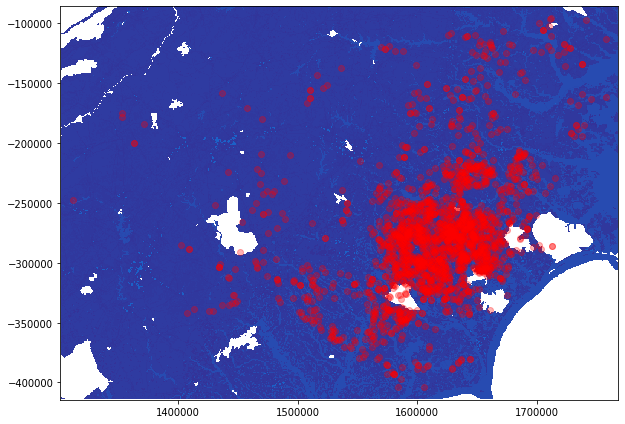

In [15]:
#Plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot.show(cost_surface_dataset,ax=ax,cmap='terrain')
gdfBG.plot(ax=ax,color='red',alpha=0.3)

In [16]:
#Iterate through all biogas site rows and create a cost distance raster
cost_arrays = [] #Cost arrays
cd_arrays = []   #Cost distance arrays, min cost distance back to source
tb_arrays = []   #Traceback arrays, for creating the least cost path

In [17]:
for i,r in gdfBG.iterrows():
    print('.',end='')
    xOffset = r['xOffset']    #get the array x coordinate of the biogas source
    yOffset = r['yOffset']    #get the array y coordinate of the biogas soruce
    z = r['Pipe Cost ($/mi-MMBtu@15y)'] / 1609.34   #Get the pipeline cost (5th col) & convert from $/mile to $/meter
    base_cost = 0          #Get the base production cost (4th col)
    
    #Create the minimum cost path (MCP) surface, setting the distance between pixels to cell sizes
    lc_graph = graph.MCP_Geometric(cost_surface_array * z , sampling=(x_size,y_size))
    #Compute cost distances away from the biogas source coordinates
    cd_array,tb_array = lc_graph.find_costs(starts=([(yOffset, xOffset)]))
    #Add the initial cost to all cells
    cd_array = ((cd_array + base_cost)*10).astype(int)
    #Add to stack of arrays
    cost_arrays.append(cost_surface_array * z)
    cd_arrays.append(cd_array)
    tb_arrays.append(tb_array)
        

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [18]:
#Create a stack of all arrays
arrCostStack = np.stack(cost_arrays)
arrCostDistanceStack =np.stack(cd_arrays)
arrTracebackStack = np.stack(tb_arrays)

#Save the array stacks to file
np.save('../data/CostStack.npy',arrCostStack)
np.save('../data/Stack.npy',arrCostDistanceStack)
np.save('../data/TraceStack.npy',arrTracebackStack)